In [ ]:
# import all the necessary libraries

import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.optimizers import Adam, RMSprop, SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard,EarlyStopping
import datetime
import matplotlib.pyplot as plt
from keras.utils import plot_model
import warnings
warnings.filterwarnings('ignore')

       angry  disgust  fear  happy  neutral   sad  surprise
train   3995      436  4097   7215     4965  4830      3171
      angry  disgust  fear  happy  neutral   sad  surprise
test    958      111  1024   1774     1233  1247       831


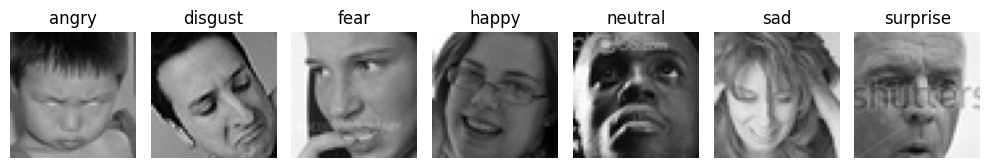

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Epoch 1/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 645s 1s/step - accuracy: 0.2440 - loss: 1.8190 - val_accuracy: 0.3107 - val_loss: 1.7233 - learning_rate: 0.0010
Epoch 2/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 407s 799ms/step - accuracy: 0.3181 - loss: 1.6935 - val_accuracy: 0.3699 - val_loss: 1.5954 - learning_rate: 0.0010
Epoch 3/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 228s 506ms/step - accuracy: 0.3785 - loss: 1.5911 - val_accuracy: 0.3975 - val_loss: 1.5400 - learning_rate: 0.0010
Epoch 4/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 219s 486ms/step - accuracy: 0.4089 - loss: 1.5187 - val_accuracy: 0.4395 - val_loss: 1.4744 - learning_rate: 0.0010
Epoch 5/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 228s 507ms/step - accuracy: 0.4229 - loss: 1.4829 - val_accuracy: 0.4542 - val_loss: 1.4243 - learning_rate: 0.0010
Epoch 6/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 263s 508ms/step - accuracy: 0.4429 - loss: 1.4485 - val_accuracy: 0.4554 - val_loss: 1.4023 - lear

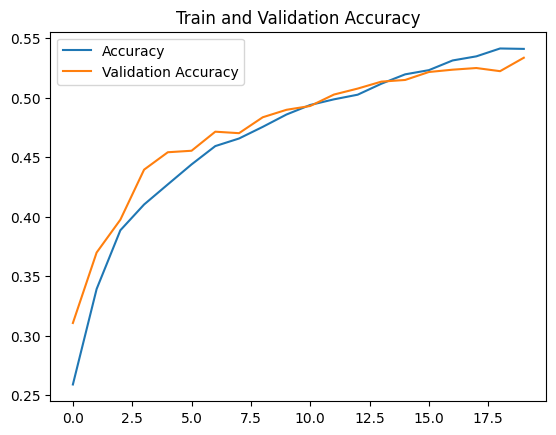

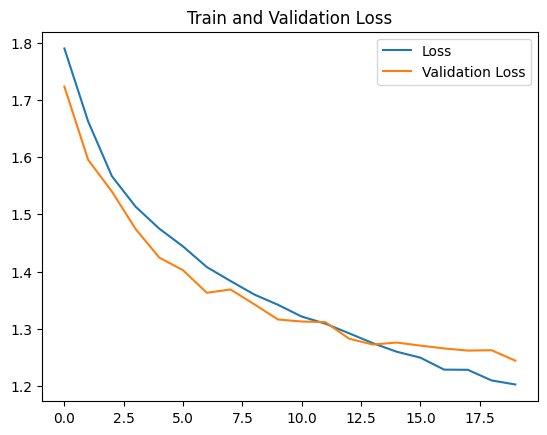

In [ ]:
# Load and train the image data

def count_exp(path, set_):
    # Check if the main path exists
    if not os.path.exists(path):
        raise FileNotFoundError(f"The specified path does not exist: {path}")
    
    dict_ = {}
    for expression in os.listdir(path):
        # Construct the full directory path using os.path.join
        dir_ = os.path.join(path, expression)
        
        # Check if it's a directory before counting files
        if os.path.isdir(dir_):
            dict_[expression] = len(os.listdir(dir_))
        else:
            print(f"Skipping {expression} because it is not a directory.")
    
    # Create a DataFrame from the dictionary
    df = pd.DataFrame(dict_, index=[set_])
    return df

# Use absolute paths for train and test directories
train_dir = r'C:\Users\user\Desktop\Data Science by Guru\My_Practices_\train'
test_dir = r'C:\Users\user\Desktop\Data Science by Guru\My_Practices_\test'

# Call the function and handle exceptions
try:
    train_count = count_exp(train_dir, 'train')
    test_count = count_exp(test_dir, 'test')
    print(train_count)
    print(test_count)
except FileNotFoundError as e:
    print(e)

# Display images from the training directory
plt.figure(figsize=(10, 18))
i = 1

for expression in os.listdir(train_dir):
    dir_path = os.path.join(train_dir, expression)
    
    # Ensure it's a directory before attempting to load images
    if os.path.isdir(dir_path):
        img_files = os.listdir(dir_path)
        
        # Check if there are any images in the directory
        if img_files:
            try:
                img_path = os.path.join(dir_path, img_files[0])  # Load the first image
                img = load_img(img_path)
                plt.subplot(1, 7, i)  # Create a subplot for each image
                plt.imshow(img)
                plt.title(expression)
                plt.axis('off')
                i += 1
                
                # Limit the number of images displayed to avoid overflow
                if i > 7:
                    break
            except Exception as e:
                print(f"Error loading image from {img_path}: {e}")
        else:
            print(f"No images found in directory: {dir_path}")

plt.tight_layout()
plt.show()


train_datagen = ImageDataGenerator(rescale = 1 / 255.,
                                   zoom_range = 0.1,
                                   shear_range = 0.1,
                                   rotation_range = 10,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest' )


val_datagen = ImageDataGenerator(rescale = 1 / 255) 

train_set = train_datagen.flow_from_directory(train_dir,
                                              batch_size = 64,
                                              target_size = (48, 48),
                                              shuffle = True,
                                              color_mode = 'grayscale',
                                              class_mode = 'categorical',)





val_set = val_datagen.flow_from_directory(test_dir,
                                            batch_size = 64,
                                            target_size = (48, 48),
                                            shuffle = True,
                                            color_mode = 'grayscale',
                                            class_mode = 'categorical',)

train_set.class_indices

inputs = tf.keras.Input(shape=(48, 48, 1))

x = Conv2D(32, 3, activation='relu', padding='same')(inputs)
x = MaxPool2D()(inputs)

x = Conv2D(64, 3, activation='relu', padding='same')(x)
x = MaxPool2D()(x)

x = Conv2D(128, 3, activation='relu', padding='same')(x)
x = MaxPool2D()(x)

x = Conv2D(256, 3, activation='relu', padding='same')(x)
x = MaxPool2D()(x)

x = Flatten()(x)

x = Dense(1024, activation='relu')(x)
x = Dense(7, activation='softmax')(x)

model = Model(inputs=inputs, outputs=x)

model.compile( loss = 'categorical_crossentropy',
               optimizer = 'adam',
               metrics = ['accuracy']
)

learning_rate = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.3)

history = model.fit(train_set, validation_data=val_set, epochs=20, callbacks=[learning_rate])

plt.figure()
plt.title('Train and Validation Accuracy')
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

plt.figure()
plt.title('Train and Validation Loss')
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()